# Data Exploration and PreProcessing Notebook
Welcome to the Data Exploration and Preprocessing Notebook for our project, delivered in Part 1 of our data science endeavor. This Jupyter notebook serves as a comprehensive guide detailing the exploration and preprocessing steps applied to the raw data. Our objective is to provide insight into the initial stages of our data analysis pipeline, including data cleansing, feature engineering, and any transformations performed on the dataset.

In this notebook, we will embark on a journey to uncover the intricacies of our dataset, understand its structure, identify potential issues, and prepare it for further analysis. By meticulously exploring and preprocessing the data, we aim to lay a solid foundation for subsequent stages of our project, enabling us to derive meaningful insights and build robust machine learning models.

## Each feature provides valuable insights into the health profile of individuals. Here's a quick overview of the key features:

- **HeartDisease:** Indicates the presence (1) or absence (0) of heart disease.
- **Smoking:** Reflects smoking habits (1 for Yes, 0 for No).
- **AlcoholDrinking:** Captures alcohol consumption habits (1 for Yes, 0 for No).
- **Stroke:** Indicates whether an individual had a stroke (1 for Yes, 0 for No).
- **DiffWalking:** Reflects difficulty walking (1 for Yes, 0 for No).
- **Sex:** Represents gender (1 for Male, 0 for Female).
- **AgeCategory:** Categorizes age into groups, such as 18-24, 25-29, ..., 80 or older.
- **Race:** Classifies individuals into different racial categories (e.g., White, Black, Hispanic).
- **Diabetic:** Indicates diabetic status (0 for No, 1 for Yes).
- **PhysicalActivity:** Reflects engagement in physical activity (1 for Yes, 0 for No).
- **GenHealth:** Rates general health on a scale from Excellent (1) to Poor (5).
- **Asthma:** Indicates asthma status (1 for Yes, 0 for No).
- **KidneyDisease:** Reflects the presence (1) or absence (0) of kidney disease.
- **SkinCancer:** Indicates whether an individual has skin cancer (1 for Yes, 0 for No).

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [31]:
class DataAnalysis:
    def __init__(self, dataset_path, target):
        """
            Initialize the DataAnalysis class.

            Parameters:
            - dataset (array-like): The dataset to be analyzed.
            - labels (array-like): The labels corresponding to each of the dataset samples.
            - columns_names (list): List of column (features) names for the dataset.

            This method initializes the DataAnalysis class by setting up the attributes
            for the dataset, labels, and column names.
            """
        self.df = pd.read_csv(dataset_path)
        self.target = target
        self.numerical_features = None
        self.categorical_features = None

        # Validate if the target column exists in the dataset
        if self.target not in self.df.columns:
            raise ValueError(f"Target column '{self.target}' not found in the dataset.")

        # Extract the labels from the target column
        self.labels = self.df[self.target]

        # Concatenate the labels to the dataset
        self.df_with_labels = pd.concat([self.df, self.labels], axis=1)

        self.valid_plot_types = ['count', 'hist', 'kde', 'correlation', 'box', 'split_violin']
        
        self.numerical_features = ["AgeCategory", "Race", "GenHealth",
                                   "BMI", "SleepTime"]
        
        self.categorical_features = ["Smoking", "AlcoholDrinking", "Stroke",
                                     "DiffWalking", "Sex", "Diabetic",
                                     "PhysicalActivity", "Asthma",
                                     "KidneyDisease", "SkinCancer"]

    def describe_variables(self):
        print("\nInformation of Data:")
        print(self.df.info())

        print("\nFeatures of Data(unique values):")
        print(self.df.nunique())

        print("\nStatistical distribution of each variable:")
        print(self.df.describe())

    def determine_range(self):

        # Display the range of values for each variable without considering the class label
        print("\nRange of values for each variable:")
        print(self.df.max() - self.df.min())

        # Display the range of values for each variable per class label
        # print("\nRange of values for each variable per class label:")
        # print(self.df_with_labels.max() - self.df_with_labels.min())

    """
            1 -> severe thinness
            2 -> moderate thinness
            3 -> mild thinness
            4 -> normal
            5 -> overweight
            6 -> obese class 1
            7 -> obese class 2
            8 -> obese class 3
        """

    def bmi_class(self):
        bmi = self.df["BMI"]
        condition = [bmi < 16, bmi < 17, bmi < 18.5, bmi < 25, bmi < 30, bmi < 35, bmi < 40, bmi >= 40]
        choice = [1, 2, 3, 4, 5, 6, 7, 8]
        self.df["BMIClass"] = np.select(condition, choice)

    def sleep_class(self):
        sleep = self.df["SleepTime"]
        condition = [sleep < 6, sleep < 9, sleep >= 9]
        choice = [1, 2, 3]
        self.df["SleepClass"] = np.select(condition, choice)

    def age_category(self):
        age = self.df["AgeCategory"]
        condition = [
            age == "18-24", age == "25-29",
            age == "30-34", age == "35-39",
            age == "40-44", age == "45-49",
            age == "50-54", age == "55-59",
            age == "60-64", age == "65-69",
            age == "70-74", age == "75-79",
            age == "80 or older"
        ]
        choice = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
        self.df["AgeCategory"] = np.select(condition, choice, default=0)

    def race_category(self):
        race = self.df["Race"]
        condition = [
            race == "White", race == "Black",
            race == "Hispanic", race == "Asian",
            race == "American Indian/Alaskan Native", race == "Other"]
        choice = [1, 2, 3, 4, 5, 6]
        self.df["Race"] = np.select(condition, choice)

    def genHealth_category(self):
        genHealth = self.df["GenHealth"]
        condition = [
            genHealth == "Excellent", genHealth == "Very good",
            genHealth == "Good", genHealth == "Fair",
            genHealth == "Poor"]
        choice = [1, 2, 3, 4, 5]
        self.df["GenHealth"] = np.select(condition, choice)

    def badHealth_feature(self):
        smoker = self.df["Smoking"]
        alcohol = self.df["AlcoholDrinking"]
        stroke = self.df["Stroke"]
        diffWalk = self.df["DiffWalking"]
        diabetic = self.df["Diabetic"]
        asthma = self.df["Asthma"]

        condition = (smoker + alcohol + stroke + diffWalk + diabetic + asthma)

        self.df["BadHealthScore"] = condition

    def process_data(self):

        # Map categorical features to numerical values
        self.df["HeartDisease"] = self.df["HeartDisease"].map({"No": 0, "Yes": 1})
        self.df["Smoking"] = self.df["Smoking"].map({"No": 0, "Yes": 1})
        self.df["AlcoholDrinking"] = self.df["AlcoholDrinking"].map({"No": 0, "Yes": 1})
        self.df["Stroke"] = self.df["Stroke"].map({"No": 0, "Yes": 1})
        self.df["DiffWalking"] = self.df["DiffWalking"].map({"No": 0, "Yes": 1})
        self.df["Sex"] = self.df["Sex"].map({"Female": 0, "Male": 1})
        self.df["Diabetic"] = self.df["Diabetic"].map(
            {"No": 0, "No, borderline diabetes": 0, "Yes (during pregnancy)": 1, "Yes": 1})
        self.df["PhysicalActivity"] = self.df["PhysicalActivity"].map({"No": 0, "Yes": 1})
        self.df["Asthma"] = self.df["Asthma"].map({"No": 0, "Yes": 1})
        self.df["KidneyDisease"] = self.df["KidneyDisease"].map({"No": 0, "Yes": 1})
        self.df["SkinCancer"] = self.df["SkinCancer"].map({"No": 0, "Yes": 1})

        # Process features
        self.age_category()
        self.race_category()
        self.genHealth_category()

        print("\nProcessed Dataset:")
        print(self.df.info())

    def assess_quality(self):

        print("\nOriginal Dataset:")
        print(self.df.info)

        print("Missing values:\n", self.df.isnull().sum())
        print("Duplicate Rows:", self.df.duplicated().sum())

        if self.df.duplicated().sum() > 0:
            self.df = self.df.drop_duplicates(keep='first')

        print("\nDetecting outliers:")
        for feature in self.df:
            
            # Check if the feature is binary (0 or 1)
            if set(self.df[feature]) == {0, 1}:
                # Skip replacing outliers for binary features
                continue
            
            q1 = self.df[feature].quantile(0.25)
            q3 = self.df[feature].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = self.df[(self.df[feature] < lower_bound) | (self.df[feature] > upper_bound)]
            print(f"Outliers in '{feature}':\n{outliers}" if not outliers.empty else f"No outliers in '{feature}'.")

            # Replace outliers with median value
            median_value = self.df[feature].median()
            self.df[feature] = np.where(
                (self.df[feature] < lower_bound) | (self.df[feature] > upper_bound),
                median_value,
                self.df[feature]
            )

        print("\nCleansed Dataset:")
        print(self.df.info)

    def plots(self, plot_types):
        for plot_type in plot_types:
            # Check if the selected plots are in the list of available plots
            if plot_type not in self.valid_plot_types:
                print(
                    f"Ignoring invalid plot type: {plot_type}. Supported plot types: {', '.join(self.valid_plot_types)}")
                continue

            for feature in self.df.columns:
                # Create a figure with a single subplot for each feature
                if plot_type == 'count' and feature in self.categorical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.countplot(x=feature, data=self.df, hue=self.target, ax=ax)
                    ax.set_title(f'Countplot of {feature} by {self.target}')
                    ax.set_xticklabels(['No', 'Yes'])
                    plt.show()
                if plot_type == 'hist':
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.histplot(x=feature, data=self.df, hue=self.target, ax=ax)
                    ax.set_title(f'Histogram of {feature}')
                    plt.show()
                if plot_type == 'kde' and feature in self.numerical_features:
                    fig, ax = plt.subplots(figsize=(13, 5))
                    sns.kdeplot(self.df[self.df["HeartDisease"] == 1][feature], alpha=0.5, shade=True, color="red",
                                label="HeartDisease", ax=ax)
                    sns.kdeplot(self.df[self.df["HeartDisease"] == 0][feature], alpha=0.5, shade=True, color="green",
                                label="Normal", ax=ax)
                    plt.title(f'Distribution of {feature}', fontsize=18)
                    ax.set_xlabel(feature)
                    ax.set_ylabel("Frequency")
                    ax.legend()
                    plt.show()
                if plot_type == 'box' and feature in self.numerical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.boxplot(x='AlcoholDrinking', y=feature, data=self.df, hue=self.target, ax=ax)
                    ax.set_title(f'Boxplot of {feature} by {self.target}')
                    plt.show()
                if plot_type == 'split_violin' and feature in self.numerical_features:
                    fig, ax = plt.subplots(figsize=(8, 6))
                    sns.violinplot(x='AlcoholDrinking', y=feature, hue=self.target, scale='count', split=True,
                                   data=self.df, ax=ax)
                    ax.set_title(f'Split Violin Plot of {feature} by {self.target}')
                    plt.show()

        if 'correlation' in plot_types:
            correlation = self.df.corr().round(2)
            plt.figure(figsize=(15, 12))
            sns.heatmap(correlation, annot=True, cmap='YlOrBr', annot_kws={'size': 8})
            plt.title('Correlation Heatmap')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

In [32]:
path = '../data/heart_2020.csv'
data_analysis_instance = DataAnalysis(path, 'HeartDisease')

### Describe Variables

Let's start by examining how many features our dataset has and checking for any null values. As we can see, no feature has null values, as we have 319795 entries for each feature, all of which are non-null. Additionally, we can observe the number of unique values for each feature below. Following that, there is a brief statistical distribution of some features.

In [33]:
data_analysis_instance.describe_variables()


Information of Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16

### Mapping Categorical Features to Numerical Values

In the initial preprocessing steps, we map categorical features to numerical values to facilitate quantitative analysis. This conversion allows us to work with statistical methods that require numerical inputs. Below is a summary of the mappings performed:

- **HeartDisease:** Mapped "No" to 0 and "Yes" to 1.
- **Smoking:** Mapped "No" to 0 and "Yes" to 1.
- **AlcoholDrinking:** Mapped "No" to 0 and "Yes" to 1.
- **Stroke:** Mapped "No" to 0 and "Yes" to 1.
- **DiffWalking:** Mapped "No" to 0 and "Yes" to 1.
- **Sex:** Mapped "Female" to 0 and "Male" to 1.
- **Diabetic:** Mapped "No" and "No, borderline diabetes" to 0, "Yes (during pregnancy)" and "Yes" to 1.
- **PhysicalActivity:** Mapped "No" to 0 and "Yes" to 1.
- **Asthma:** Mapped "No" to 0 and "Yes" to 1.
- **KidneyDisease:** Mapped "No" to 0 and "Yes" to 1.
- **SkinCancer:** Mapped "No" to 0 and "Yes" to 1.

We observed that the data type of some features was initially stored as 'object.' To enhance our analysis, these features were converted to 'int64'


In [34]:
data_analysis_instance.process_data()


Processed Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   Sex               319795 non-null  int64  
 9   AgeCategory       319795 non-null  int32  
 10  Race              319795 non-null  int32  
 11  Diabetic          319795 non-null  int64  
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  int32  
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  int64  
 16  

## Range of values for each variable:

In [35]:
data_analysis_instance.determine_range()


Range of values for each variable:
HeartDisease         1.00
BMI                 82.83
Smoking              1.00
AlcoholDrinking      1.00
Stroke               1.00
PhysicalHealth      30.00
MentalHealth        30.00
DiffWalking          1.00
Sex                  1.00
AgeCategory         12.00
Race                 5.00
Diabetic             1.00
PhysicalActivity     1.00
GenHealth            4.00
SleepTime           23.00
Asthma               1.00
KidneyDisease        1.00
SkinCancer           1.00
dtype: float64


# Outliers and Correlation
Os principais factores de risco cardiovascular, sobre os quais pode agir a prevenção, são os seguintes:

Sedentarismo
Hipertensão
Tabagismo
Stress
Obesidade
Diabetes
Dislipidemia


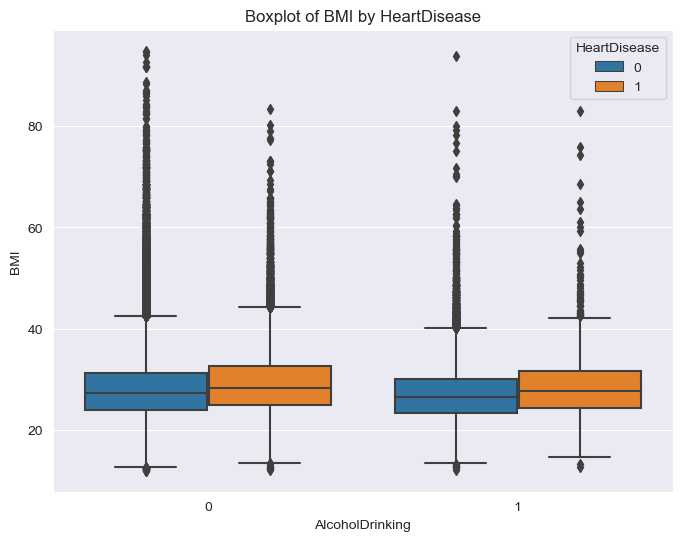

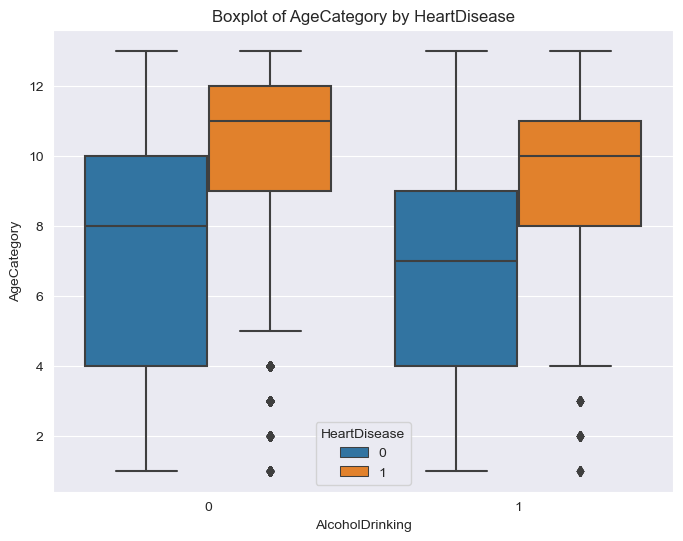

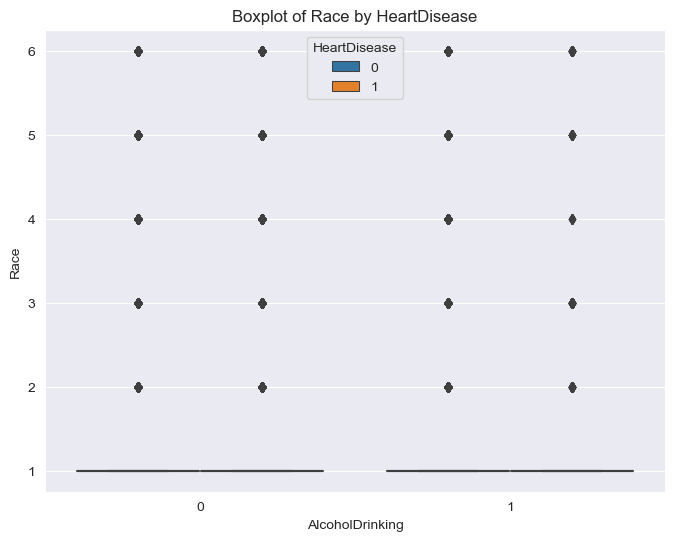

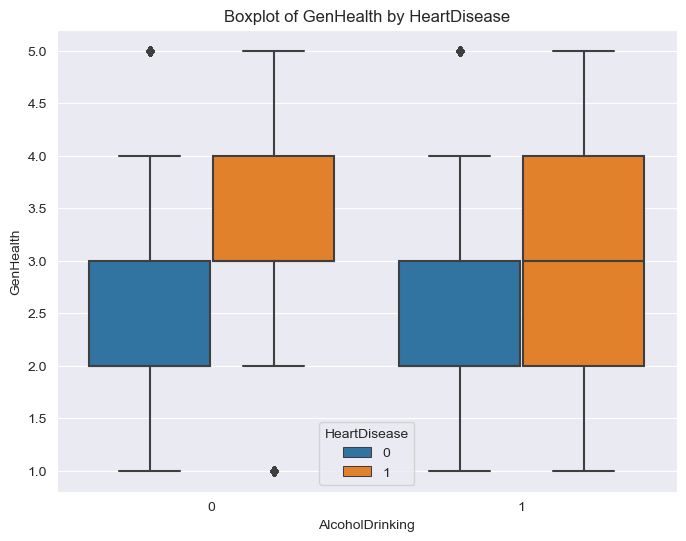

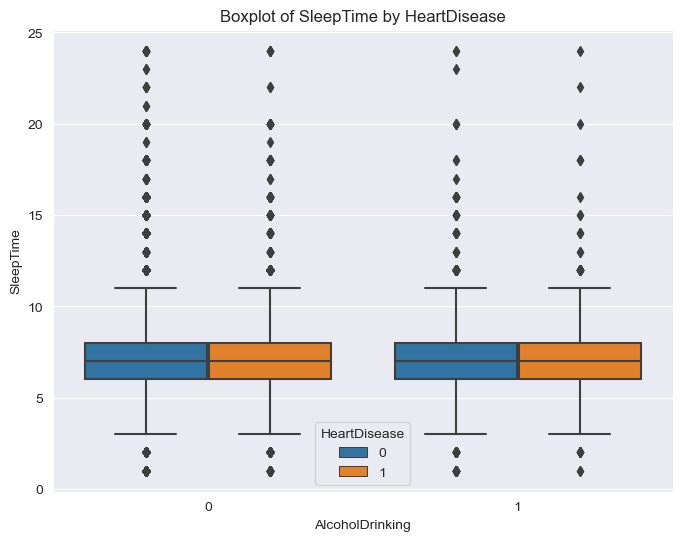

In [36]:
data_analysis_instance.plots(['box'])

# Replace duplicated data with median

In the process of working with datasets, it is crucial to ensure the quality and integrity of the data. This involves identifying and addressing issues such as missing values, duplicate rows, and outliers. The `assess_quality` function presented below is designed to perform a comprehensive assessment of the dataset and take corrective actions where necessary.


In [37]:
data_analysis_instance.assess_quality()


Original Dataset:
<bound method DataFrame.info of         HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0                  0  16.60        1                0       0             3.0   
1                  0  20.34        0                0       1             0.0   
2                  0  26.58        1                0       0            20.0   
3                  0  24.21        0                0       0             0.0   
4                  0  23.71        0                0       0            28.0   
...              ...    ...      ...              ...     ...             ...   
319790             1  27.41        1                0       0             7.0   
319791             0  29.84        1                0       0             0.0   
319792             0  24.24        0                0       0             0.0   
319793             0  32.81        0                0       0             0.0   
319794             0  46.56        0                0     

# Countplots for Categorical Features

Let's visualize the distribution of our categorical features using countplots. These plots provide a clear overview of the frequency of each category within the dataset.


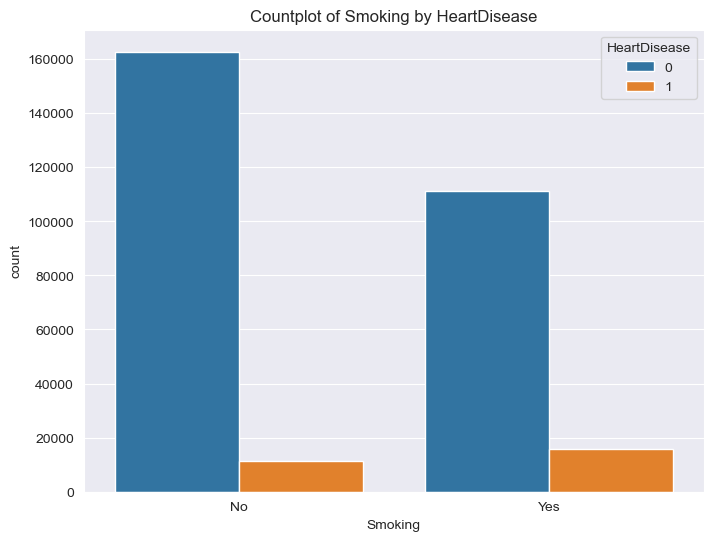

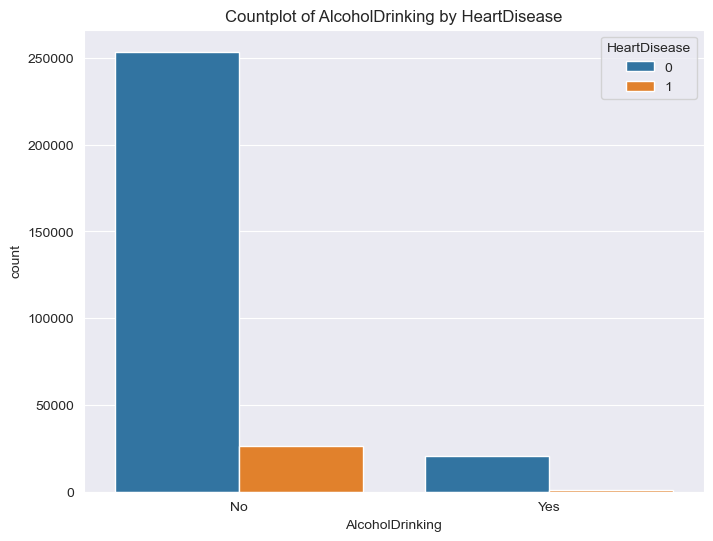

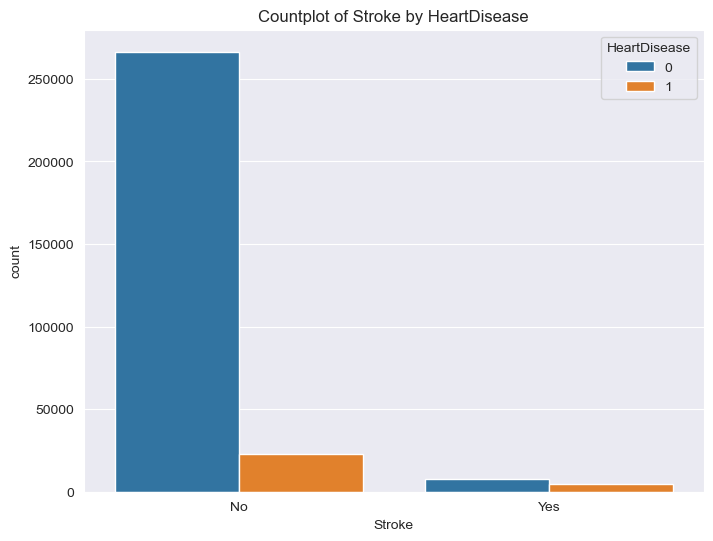

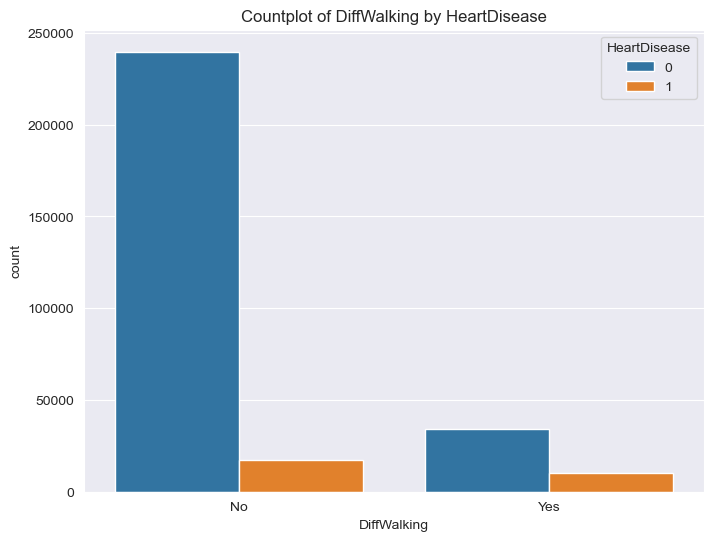

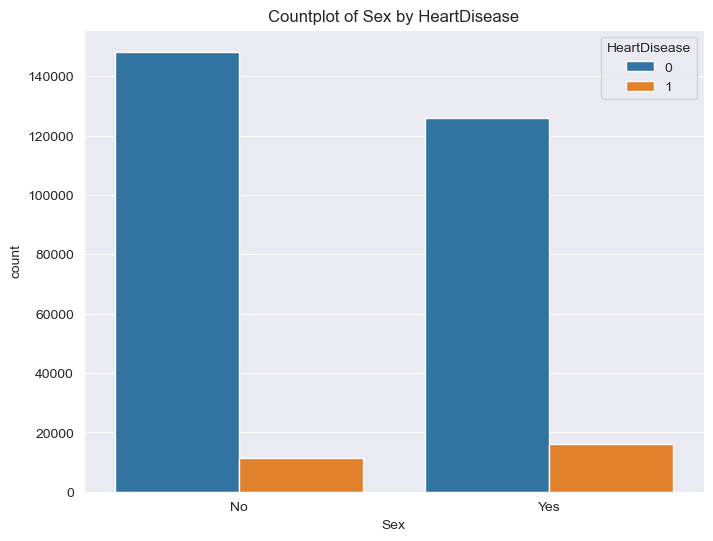

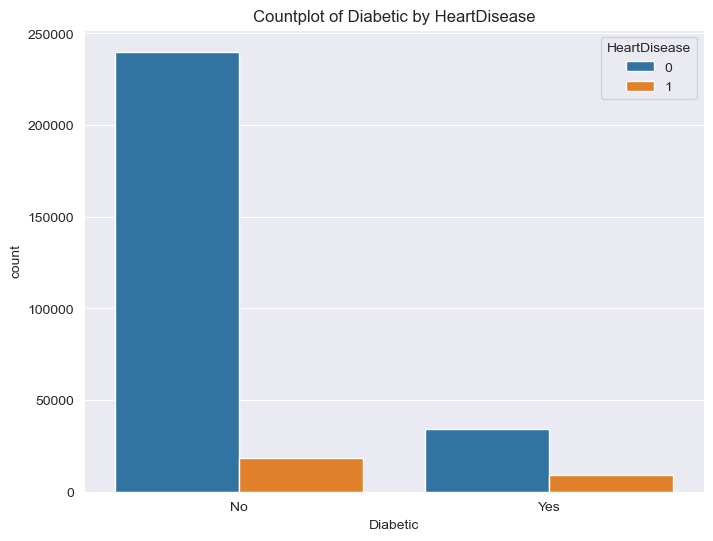

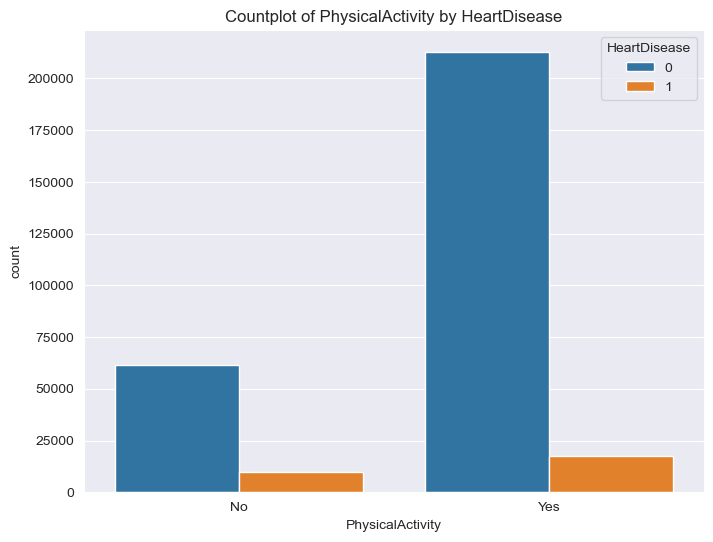

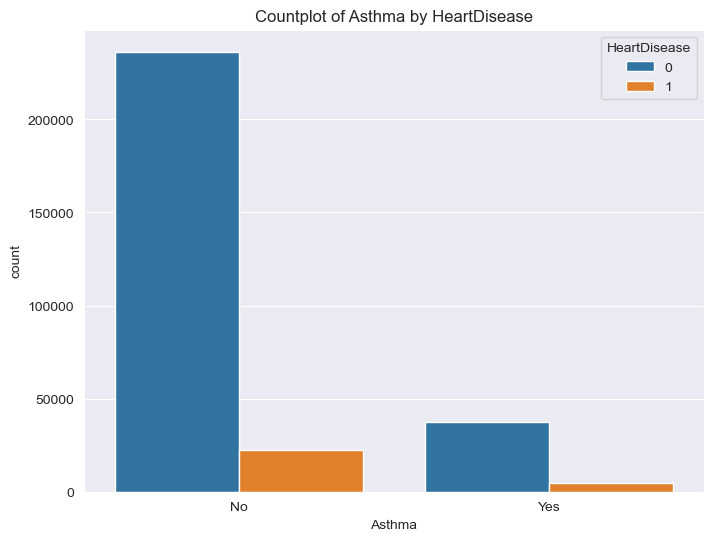

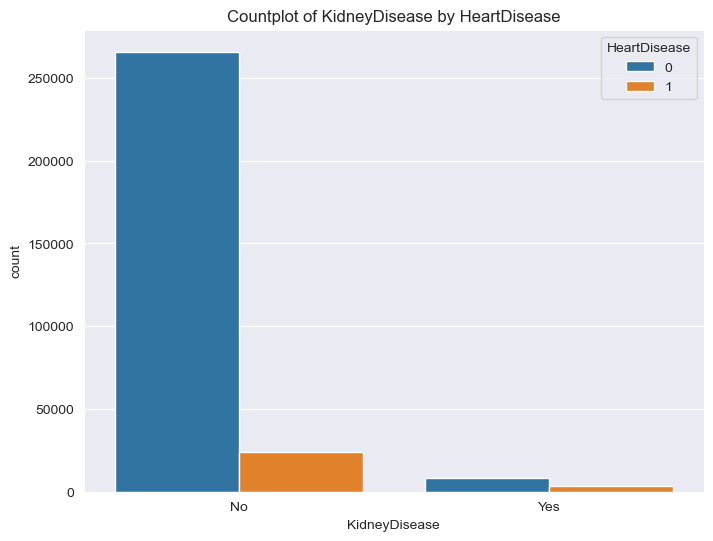

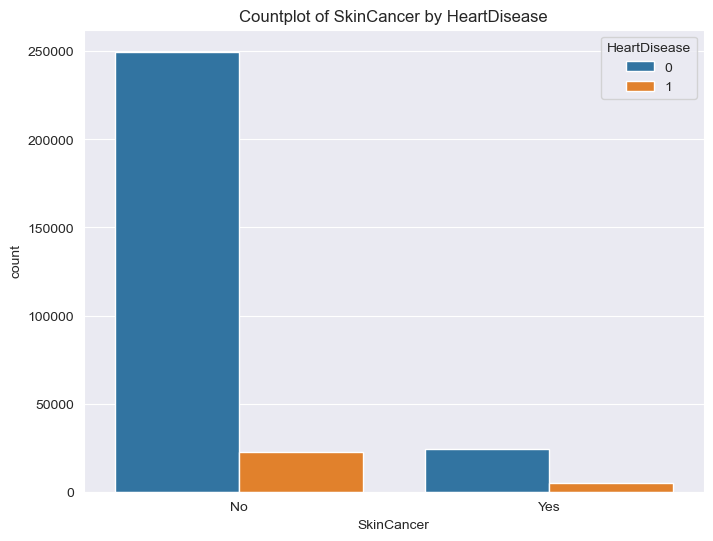

In [38]:
data_analysis_instance.plots(['count'])

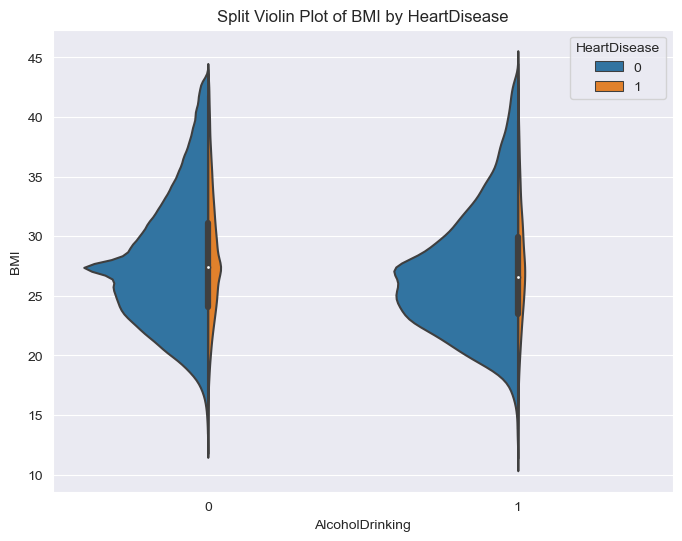

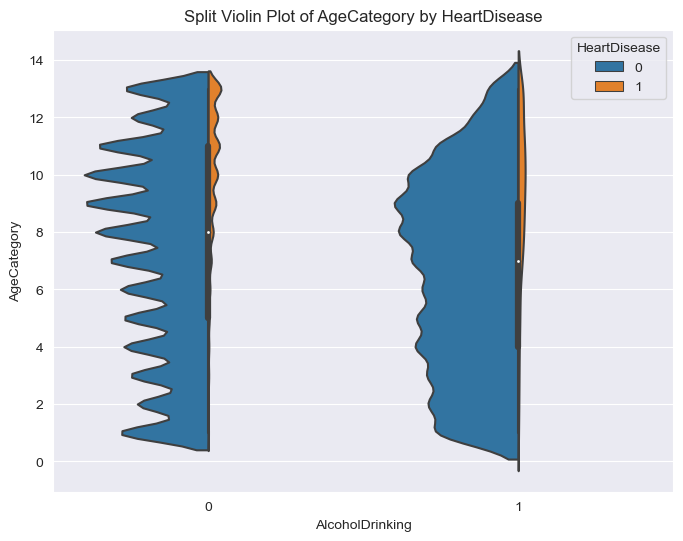

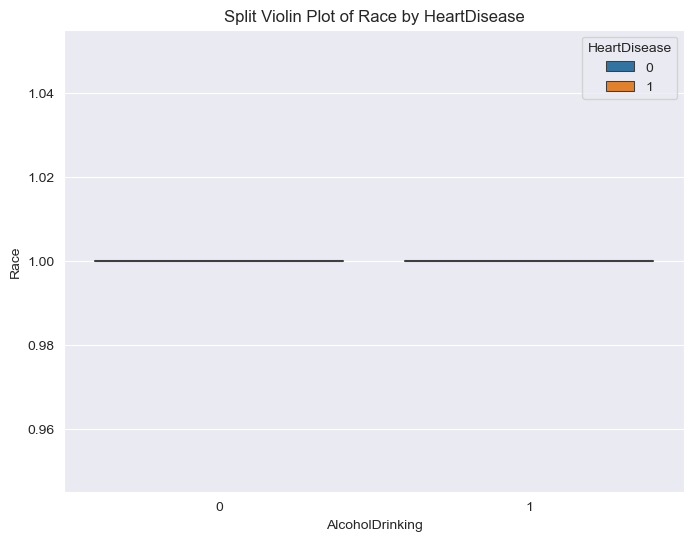

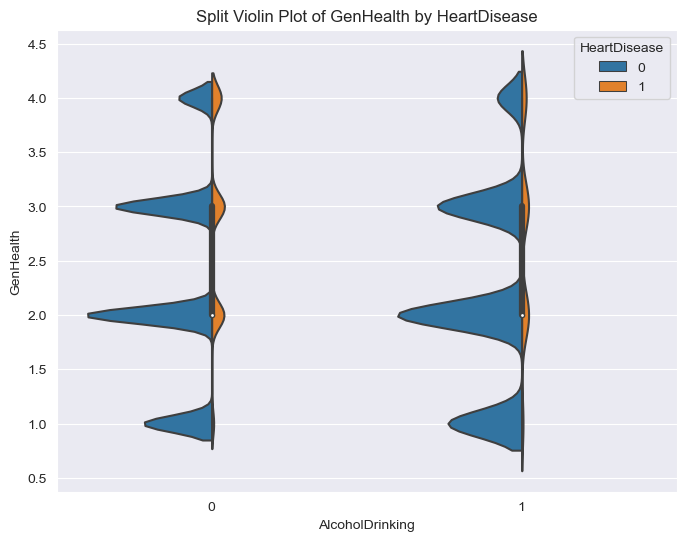

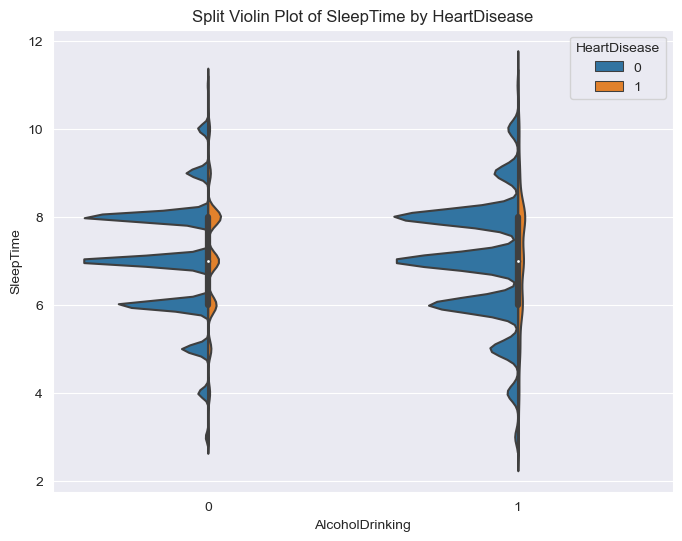

In [39]:
data_analysis_instance.plots(['split_violin'])